In [235]:
# import library
import numpy as np 
import pandas as pd
import re
import os
import nltk 
import string
import re

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

from functools import partial
from keras import metrics

In [236]:
#MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
#MAX_NB_WORDS = 6000 # Vocabulary size
#EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [237]:
# open dataset,save on dataframe
df = pd.read_csv("dataset/dataset.csv",encoding="ISO-8859-1")
    
df.head()

,created_at,screen_name,text,label
0,5/1/2021 16:48,theoholan,itu mah konflik rebutan tanah,0
1,5/3/2021 14:12,KoloElang,Bisa tidak? Palestina taat secara kaffah dala...,0
2,5/4/2021 5:55,viktorkonyolsky,Bagaimana mengelola/ menghadapi pemberontakan...,0
3,5/5/2021 10:27,ambiszen,kalau palestina rohingya lebih ke konflik poli...,1
4,5/5/2021 10:54,NephiLaxmus,Teroris 'islam' Itu gejala baru terutama seba...,1


In [238]:
# drop column created_at and screen_name
df = df.drop(['created_at', 'screen_name'], axis=1)

In [227]:
df

,text,label
0,itu mah konflik rebutan tanah,0
1,Bisa tidak? Palestina taat secara kaffah dala...,0
2,Bagaimana mengelola/ menghadapi pemberontakan...,0
3,kalau palestina rohingya lebih ke konflik poli...,1
4,Teroris 'islam' Itu gejala baru terutama seba...,1
...,...,...
1541,"Satukan hati, satukan tekad,satulan langkah, ...",1
1542,@JatIkhwan Saya kok ngelihatnya gencatan senj...,1
1543,Mungkin mereka bergembira mau merayakan Genca...,1
1544,Agak lucu aja sih liat orang pada jadi die ha...,2


In [239]:
#remove user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt   
df['remove_user'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")

In [240]:
df

,text,label,remove_user
0,itu mah konflik rebutan tanah,0,itu mah konflik rebutan tanah
1,Bisa tidak? Palestina taat secara kaffah dala...,0,Bisa tidak? Palestina taat secara kaffah dala...
2,Bagaimana mengelola/ menghadapi pemberontakan...,0,Bagaimana mengelola/ menghadapi pemberontakan...
3,kalau palestina rohingya lebih ke konflik poli...,1,kalau palestina rohingya lebih ke konflik poli...
4,Teroris 'islam' Itu gejala baru terutama seba...,1,Teroris 'islam' Itu gejala baru terutama seba...
...,...,...,...
1541,"Satukan hati, satukan tekad,satulan langkah, ...",1,"Satukan hati, satukan tekad,satulan langkah, ..."
1542,@JatIkhwan Saya kok ngelihatnya gencatan senj...,1,Saya kok ngelihatnya gencatan senjata ini se...
1543,Mungkin mereka bergembira mau merayakan Genca...,1,Mungkin mereka bergembira mau merayakan Genca...
1544,Agak lucu aja sih liat orang pada jadi die ha...,2,Agak lucu aja sih liat orang pada jadi die ha...


In [241]:
def remove(tweet):
    #remove angka
    tweet = re.sub('[0-9]+', '', tweet)
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    return tweet
df['remove_http'] = df['remove_user'].apply(lambda x: remove(x))

In [242]:
df.head(10)

,text,label,remove_user,remove_http
0,itu mah konflik rebutan tanah,0,itu mah konflik rebutan tanah,itu mah konflik rebutan tanah
1,Bisa tidak? Palestina taat secara kaffah dala...,0,Bisa tidak? Palestina taat secara kaffah dala...,Bisa tidak? Palestina taat secara kaffah dala...
2,Bagaimana mengelola/ menghadapi pemberontakan...,0,Bagaimana mengelola/ menghadapi pemberontakan...,Bagaimana mengelola/ menghadapi pemberontakan...
3,kalau palestina rohingya lebih ke konflik poli...,1,kalau palestina rohingya lebih ke konflik poli...,kalau palestina rohingya lebih ke konflik poli...
4,Teroris 'islam' Itu gejala baru terutama seba...,1,Teroris 'islam' Itu gejala baru terutama seba...,Teroris 'islam' Itu gejala baru terutama seba...
5,@mataglo @Sentjoko paling sedikit gregetan gu...,2,paling sedikit gregetan gue turun karena ka...,paling sedikit gregetan gue turun karena ka...
6,Meningkatnya ketidakpercayaan antara bangsa Ar...,0,Meningkatnya ketidakpercayaan antara bangsa Ar...,Meningkatnya ketidakpercayaan antara bangsa Ar...
7,Tolong negara negara arab atau lainnya harus ...,1,Tolong negara negara arab atau lainnya harus ...,Tolong negara negara arab atau lainnya harus ...
8,Apa kalian yang teriak toleransi tau bagaiman...,2,Apa kalian yang teriak toleransi tau bagaiman...,Apa kalian yang teriak toleransi tau bagaiman...
9,@Sk8rwannabe memang. konflik israel-palestina...,2,memang. konflik israel-palestina memang komp...,memang. konflik israel-palestina memang komp...


In [243]:
df

,text,label,remove_user,remove_http
0,itu mah konflik rebutan tanah,0,itu mah konflik rebutan tanah,itu mah konflik rebutan tanah
1,Bisa tidak? Palestina taat secara kaffah dala...,0,Bisa tidak? Palestina taat secara kaffah dala...,Bisa tidak? Palestina taat secara kaffah dala...
2,Bagaimana mengelola/ menghadapi pemberontakan...,0,Bagaimana mengelola/ menghadapi pemberontakan...,Bagaimana mengelola/ menghadapi pemberontakan...
3,kalau palestina rohingya lebih ke konflik poli...,1,kalau palestina rohingya lebih ke konflik poli...,kalau palestina rohingya lebih ke konflik poli...
4,Teroris 'islam' Itu gejala baru terutama seba...,1,Teroris 'islam' Itu gejala baru terutama seba...,Teroris 'islam' Itu gejala baru terutama seba...
...,...,...,...,...
1541,"Satukan hati, satukan tekad,satulan langkah, ...",1,"Satukan hati, satukan tekad,satulan langkah, ...","Satukan hati, satukan tekad,satulan langkah, ..."
1542,@JatIkhwan Saya kok ngelihatnya gencatan senj...,1,Saya kok ngelihatnya gencatan senjata ini se...,Saya kok ngelihatnya gencatan senjata ini se...
1543,Mungkin mereka bergembira mau merayakan Genca...,1,Mungkin mereka bergembira mau merayakan Genca...,Mungkin mereka bergembira mau merayakan Genca...
1544,Agak lucu aja sih liat orang pada jadi die ha...,2,Agak lucu aja sih liat orang pada jadi die ha...,Agak lucu aja sih liat orang pada jadi die ha...


In [244]:
#import stopword
from nltk.corpus import stopwords 
#stopwords_indonesia = stopwords.words('indonesian')
# Create Stopword
with open("Stopword.txt", "r") as f:
    stopwords_indonesia = f.readline().split()
 
#import sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#tokenize
from nltk.tokenize import TweetTokenizer
 
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

additional_char = set([
    'nTTTTT', 'T\n', '&amp',
    'n1','n2','n3','n4','n5', 'n6', 'n7', 'n8', 'n9',
    'x8', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x8a', 'x8b', 'x8c', 'x8d', 'x8e', 'x8f',
    'x9', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x9c', 'x9d', 'x9e', 'x9f',
    'xa', 'xa0', 'xa1', 'xa2', 'xa3', 'xa4', 'xa5', 'xa6', 'xa7', 'xa8', 'xa9', 'xaa', 'xac', 'xad', 'xae',
    'xb', 'xb0', 'xb1', 'xb2', 'xb3', 'xb4', 'xb5', 'xb6', 'xb7', 'xb8', 'xb9', 'xba', 'xab', 'xbb', 'xbc', 'xbd',
    'xc', 'xc1', 'xc2', 'xe2', 'xef', 'xf', 'xf0' 
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)
 
def clean_tweets(tweet):
    
    #Convert to lower case
    tweet  = tweet.lower()
    
    #Convert www.* or https?://* to ''
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1',tweet)
    
    # remove old style retweet text "RT" dan karakter yang tidak dibutuhkan
    tweet = re.sub(r"b'rt", '', tweet)
    tweet = re.sub(r"b'", '', tweet)
    tweet = re.sub(r'b"', '', tweet)
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_indonesia and # remove stopwords
              word not in emoticons and # remove emoticons
                    word not in additional_char and #remove add_char
                        word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)
 
    return tweets_clean

In [245]:
df['tweet_clean'] = df['remove_http'].apply(lambda x: clean_tweets(x))

In [246]:
df

,text,label,remove_user,remove_http,tweet_clean
0,itu mah konflik rebutan tanah,0,itu mah konflik rebutan tanah,itu mah konflik rebutan tanah,"[itu, mah, konflik, rebut, tanah]"
1,Bisa tidak? Palestina taat secara kaffah dala...,0,Bisa tidak? Palestina taat secara kaffah dala...,Bisa tidak? Palestina taat secara kaffah dala...,"[bisa, tidak, palestina, taat, cara, kaffah, d..."
2,Bagaimana mengelola/ menghadapi pemberontakan...,0,Bagaimana mengelola/ menghadapi pemberontakan...,Bagaimana mengelola/ menghadapi pemberontakan...,"[bagaimana, kelola, hadap, ronta, runding, unt..."
3,kalau palestina rohingya lebih ke konflik poli...,1,kalau palestina rohingya lebih ke konflik poli...,kalau palestina rohingya lebih ke konflik poli...,"[kalau, palestina, rohingya, lebih, ke, konfli..."
4,Teroris 'islam' Itu gejala baru terutama seba...,1,Teroris 'islam' Itu gejala baru terutama seba...,Teroris 'islam' Itu gejala baru terutama seba...,"[teroris, islam, itu, gejala, baru, utama, bag..."
...,...,...,...,...,...
1541,"Satukan hati, satukan tekad,satulan langkah, ...",1,"Satukan hati, satukan tekad,satulan langkah, ...","Satukan hati, satukan tekad,satulan langkah, ...","[satu, hati, satu, tekad, satulan, langkah, sa..."
1542,@JatIkhwan Saya kok ngelihatnya gencatan senj...,1,Saya kok ngelihatnya gencatan senjata ini se...,Saya kok ngelihatnya gencatan senjata ini se...,"[saya, kok, ngelihatnya, gencat, senjata, ini,..."
1543,Mungkin mereka bergembira mau merayakan Genca...,1,Mungkin mereka bergembira mau merayakan Genca...,Mungkin mereka bergembira mau merayakan Genca...,"[mungkin, mereka, gembira, mau, raya, gencat, ..."
1544,Agak lucu aja sih liat orang pada jadi die ha...,2,Agak lucu aja sih liat orang pada jadi die ha...,Agak lucu aja sih liat orang pada jadi die ha...,"[agak, lucu, aja, sih, liat, orang, pada, jadi..."


In [247]:
def remove_punct(text):
    text  = " ".join([char for char in text if char not in string.punctuation])
    return text

In [248]:
df['Tweet'] = df['tweet_clean'].apply(lambda x: remove_punct(x))

In [252]:
df

,label,Tweet
0,0,itu mah konflik rebut tanah
1,0,bisa tidak palestina taat cara kaffah dalam is...
2,0,bagaimana kelola hadap ronta runding untuk pak...
3,1,kalau palestina rohingya lebih ke konflik poli...
4,1,teroris islam itu gejala baru utama bagai imba...
...,...,...
1541,1,satu hati satu tekad satulan langkah sama buru...
1542,1,saya kok ngelihatnya gencat senjata ini sengaj...
1543,1,mungkin mereka gembira mau raya gencat senjata...
1544,2,agak lucu aja sih liat orang pada jadi die har...


In [254]:
# delete missing value 
nan_value = float('NaN')
df.replace('', nan_value, inplace=True)
df.dropna(subset=['Tweet'], inplace=True)

In [255]:
# delete missing value 
nan_value = float('NaN')
df.replace('', nan_value, inplace=True)
df.dropna(subset=['Tweet'], inplace=True)

In [256]:
df

,label,Tweet
0,0,itu mah konflik rebut tanah
1,0,bisa tidak palestina taat cara kaffah dalam is...
2,0,bagaimana kelola hadap ronta runding untuk pak...
3,1,kalau palestina rohingya lebih ke konflik poli...
4,1,teroris islam itu gejala baru utama bagai imba...
...,...,...
1541,1,satu hati satu tekad satulan langkah sama buru...
1542,1,saya kok ngelihatnya gencat senjata ini sengaj...
1543,1,mungkin mereka gembira mau raya gencat senjata...
1544,2,agak lucu aja sih liat orang pada jadi die har...


1    661
0    522
2    363
Name: label, dtype: int64


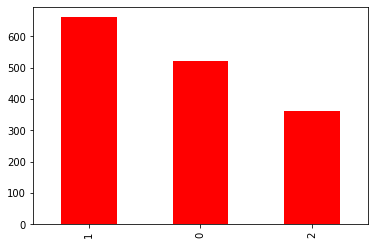

In [257]:
# menghitung Label sentimen (menampilkan tabel pembagian label sentimen)
labels = df.label
labels_count = labels.value_counts()
labels_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(labels.value_counts())

In [258]:
# convert to CSV
df.to_csv('dataclean.csv', encoding='utf-8', index=False)

In [259]:
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.Tweet)
sequences = tokenizer.texts_to_sequences(df.Tweet)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [260]:
print('Found %d unique words.' % len(word_index))

Found 3462 unique words.


In [261]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [262]:
# Prepare to y as label
y = df["label"]
y = to_categorical(y)

In [263]:
classes = ['0', '1', '2']

In [294]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20, stratify=y)

In [282]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [283]:
# Use GloVe as Word Embedding
hits = 0
misses = 0
index = []
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [284]:
test = embeddings_index.get("netizen")
test

array([-4.327230e-01, -3.119420e-01,  1.094491e+00, -2.145950e-01,
        7.534390e-01,  1.659070e+00,  4.936180e-01,  1.409000e-03,
        4.884600e-01,  2.542550e-01, -4.979390e-01,  5.617340e-01,
        7.850000e-04,  4.132720e-01, -1.368150e-01, -9.046870e-01,
        1.362670e-01,  4.538210e-01, -5.378070e-01, -3.954030e-01,
        4.325460e-01,  1.985550e-01,  9.402100e-01,  7.971500e-01,
       -3.500120e-01, -1.429267e+00, -2.684250e-01,  1.794200e-02,
       -5.229970e-01, -3.316800e-02, -6.168300e-02, -3.128350e-01,
        6.554350e-01,  6.181870e-01, -6.873700e-01, -4.817520e-01,
       -3.157320e-01,  5.082510e-01, -7.406850e-01,  3.074100e-01,
       -1.201028e+00, -1.213599e+00,  1.140920e-01,  3.905700e-02,
        6.468660e-01, -1.947500e-02, -4.191220e-01, -5.519950e-01,
        6.553630e-01,  4.248600e-01], dtype=float32)

In [285]:
# Embedding layer with glove
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True)

In [286]:
# Create Model CNN
# model 2
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
#     model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(GlobalMaxPooling1D())
#     model.add(Flatten())
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [159]:
# Train Model
cnn_model = create_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 50)            224750    
                                                                 
 conv1d_4 (Conv1D)           (None, 50, 128)           19328     
                                                                 
 dropout_8 (Dropout)         (None, 50, 128)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 25, 128)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 25, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 25, 64)            24640     
                                                      

In [295]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
25/25 [==============================] - 1s 31ms/step - loss: 0.0335 - accuracy: 0.9974 - val_loss: 3.6424 - val_accuracy: 0.9069
Epoch 2/10
25/25 [==============================] - 1s 33ms/step - loss: 0.0018 - accuracy: 0.9987 - val_loss: 4.1171 - val_accuracy: 0.9056
Epoch 3/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0265 - accuracy: 0.9987 - val_loss: 3.6120 - val_accuracy: 0.9082
Epoch 4/10
25/25 [==============================] - 1s 32ms/step - loss: 0.0034 - accuracy: 0.9987 - val_loss: 3.7649 - val_accuracy: 0.9082
Epoch 5/10
25/25 [==============================] - 1s 28ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.8467 - val_accuracy: 0.9056
Epoch 6/10
25/25 [==============================] - 1s 33ms/step - loss: 7.2768e-04 - accuracy: 1.0000 - val_loss: 3.8620 - val_accuracy: 0.9056
Epoch 7/10
25/25 [==============================] - 1s 27ms/step - loss: 2.6858e-05 - accuracy: 1.0000 - val_loss: 3.8644 - val_accuracy: 0.9056
Epoch

CNN Accuracy: 0.5483870967741935


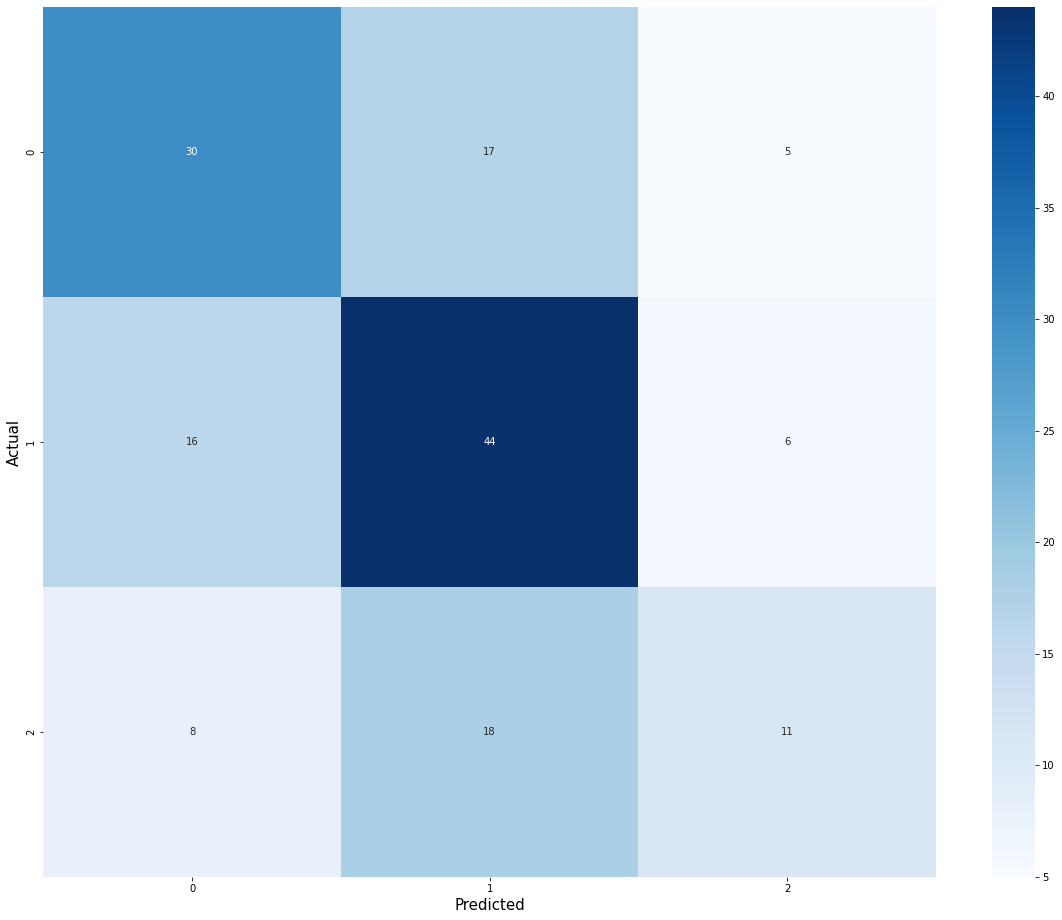

In [291]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [289]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=-1), ypred.argmax(axis=-1),target_names= classes))

              precision    recall  f1-score   support

           0       0.62      0.56      0.59        52
           1       0.58      0.68      0.62        66
           2       0.40      0.32      0.36        37

    accuracy                           0.55       155
   macro avg       0.53      0.52      0.52       155
weighted avg       0.55      0.55      0.55       155



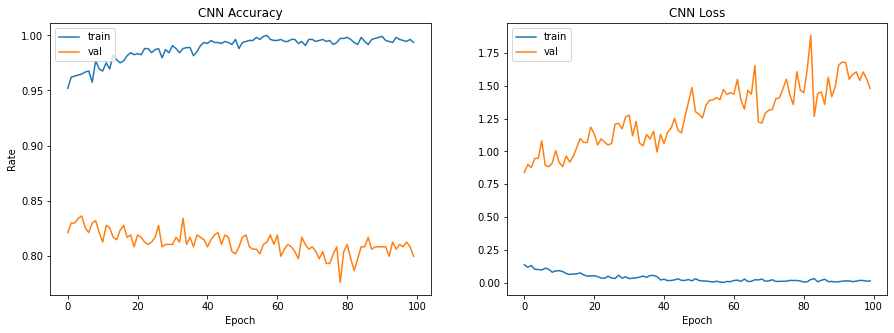

In [280]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()